# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
from lib.dataeng import Etl

In [4]:
etl = Etl()
etl.repo

'/home/benjamin/Downloads/'

In [5]:
df_weight_raw = etl._extract_poids() # extrait toutes les mesures de poids


Le fichier poids le plus récent est : data_BEN_1709012531.zip, parmi :
data_BEN_1708497738.zip
data_BEN_1708580428.zip
data_BEN_1709012531.zip
data_BEN_1708763698.zip
data_BEN_1708405395.zip
data_BEN_1708327447.zip
data_BEN_1708674104.zip
data_BEN_1708234834.zip
data_BEN_1708930745.zip
data_BEN_1708837497.zip


In [6]:
df_weight = df_weight_raw.groupby(['Date']).mean()

In [7]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-02-13,73.218000,12.408000,3.038667,57.756000,40.813333,0.169466,1683.4960
2024-02-14,73.686000,12.185333,3.077333,58.408000,41.516000,0.165367,1698.4144
2024-02-15,74.404667,11.867333,3.137333,59.384667,42.605333,0.159497,1720.8064
2024-02-16,73.769333,12.443333,3.066667,58.245333,41.292000,0.168677,1694.6416
2024-02-17,74.114000,12.265333,3.096000,58.736667,41.828000,0.165492,1705.9312
2024-02-18,74.788125,12.853125,3.096250,58.823750,41.781250,0.171859,1707.7960
2024-02-19,74.280000,12.382000,3.098000,58.784000,41.847000,0.166692,1706.9968
2024-02-20,74.232000,12.179333,3.106667,58.930667,42.046000,0.164070,1710.3376
2024-02-21,73.602667,12.854000,3.033333,57.698667,40.682667,0.174638,1682.1712


In [8]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-02-13,72.648667,12.206363,3.021482,57.405917,40.505851,0.168018,1675.553757
2024-02-14,72.746000,12.237506,3.024911,57.468964,40.562423,0.168224,1676.983471
2024-02-15,73.003810,12.154000,3.043905,57.791238,40.908095,0.166508,1684.355886
2024-02-16,73.239238,12.207333,3.053048,57.964190,41.070000,0.166697,1688.289143
2024-02-17,73.516762,12.223905,3.066762,58.211429,41.314476,0.166290,1693.925714
2024-02-18,73.862494,12.335589,3.078417,58.433679,41.512845,0.167012,1698.981143
2024-02-19,74.037161,12.343494,3.087179,58.591202,41.668988,0.166721,1702.583200
2024-02-20,74.182018,12.310827,3.096893,58.759012,41.845083,0.165951,1706.417714
2024-02-21,74.170113,12.406351,3.090607,58.657679,41.726036,0.167275,1704.097257


In [9]:
df_food_raw = etl._extract_food()  # calories par jour par repas


Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-02-27.zip, parmi
File-Export-2020-08-03-to-2024-02-21.zip
File-Export-2020-08-03-to-2024-02-26.zip
File-Export-2020-08-03-to-2024-02-27.zip
File-Export-2020-08-03-to-2024-02-24.zip
File-Export-2020-08-03-to-2024-02-18.zip
File-Export-2020-08-03-to-2024-02-25.zip
File-Export-2020-08-03-to-2024-02-19.zip
File-Export-2020-08-03-to-2024-02-20.zip
File-Export-2020-08-03-to-2024-02-23.zip
File-Export-2020-08-03-to-2024-02-22.zip


In [10]:
df_food = df_food_raw.groupby(['Date']).sum(numeric_only=True)

In [11]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2024-02-12,2687.5,100.1,259.5,199.7
2024-02-13,1274.3,28.1,135.0,126.7
2024-02-14,1947.7,82.6,152.7,147.2
2024-02-15,1704.8,53.2,90.1,199.1
2024-02-16,1884.3,46.5,163.3,154.2
2024-02-17,2364.3,76.0,224.8,204.4
2024-02-18,1711.0,40.2,179.5,166.2
2024-02-19,1712.7,56.8,126.2,179.1
2024-02-20,1720.5,26.4,180.4,203.2


In [12]:
df_exos_raw = etl._extract_exos()


Le fichier exercices le plus récent est : polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip, parmi :
polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip
polar-user-data-export_12baa4ce-79a5-40f8-ad40-74308f7c2c26.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1924/1924 [00:57<00:00, 33.27it/s]


In [13]:
df_exos_total = df_exos_raw.groupby(['exo_date']).sum(numeric_only=True)

In [14]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-02-11,3120.732,476.0
2024-02-12,5940.983,530.0
2024-02-13,1500.000,100.0
2024-02-14,5820.000,250.0
2024-02-15,7064.704,436.0
2024-02-16,13380.705,850.0
2024-02-17,4620.000,300.0
2024-02-18,10020.702,540.0
2024-02-19,8580.000,400.0


In [15]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-02-11,2117.687000,269.857143
2024-02-12,2966.398857,345.571429
2024-02-13,2820.566429,304.857143
2024-02-14,3223.305286,290.000000
2024-02-15,4232.548714,352.285714
2024-02-16,5681.136143,434.857143
2024-02-17,5921.017714,420.285714
2024-02-18,6906.727714,429.428571
2024-02-19,7283.730143,410.857143


In [16]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [17]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [18]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [19]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-02-12,73.057333,12.326667,3.036667,57.681333,40.754000,0.168726,1681.7824,2687.5,100.1,259.5,199.7,5940.983,530.0,414.358326,2096.140726,591.359274
2024-02-13,73.218000,12.408000,3.038667,57.756000,40.813333,0.169466,1683.4960,1274.3,28.1,135.0,126.7,1500.000,100.0,70.772639,1754.268639,-479.968639
2024-02-14,73.686000,12.185333,3.077333,58.408000,41.516000,0.165367,1698.4144,1947.7,82.6,152.7,147.2,5820.000,250.0,135.592919,1834.007319,113.692681
2024-02-15,74.404667,11.867333,3.137333,59.384667,42.605333,0.159497,1720.8064,1704.8,53.2,90.1,199.1,7064.704,436.0,295.294122,2016.100522,-311.300522
2024-02-16,73.769333,12.443333,3.066667,58.245333,41.292000,0.168677,1694.6416,1884.3,46.5,163.3,154.2,13380.705,850.0,587.552091,2282.193691,-397.893691
2024-02-17,74.114000,12.265333,3.096000,58.736667,41.828000,0.165492,1705.9312,2364.3,76.0,224.8,204.4,4620.000,300.0,208.780068,1914.711268,449.588732
2024-02-18,74.788125,12.853125,3.096250,58.823750,41.781250,0.171859,1707.7960,1711.0,40.2,179.5,166.2,10020.702,540.0,341.929227,2049.725227,-338.725227
2024-02-19,74.280000,12.382000,3.098000,58.784000,41.847000,0.166692,1706.9968,1712.7,56.8,126.2,179.1,8580.000,400.0,230.485734,1937.482534,-224.782534
2024-02-20,74.232000,12.179333,3.106667,58.930667,42.046000,0.164070,1710.3376,1720.5,26.4,180.4,203.2,2400.000,150.0,102.490622,1812.828222,-92.328222
2024-02-21,73.602667,12.854000,3.033333,57.698667,40.682667,0.174638,1682.1712,1765.6,38.2,155.5,207.4,3490.972,361.0,293.032262,1975.203462,-209.603462


In [20]:
df_all.rolling(window=15).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-02-12,72.950833,12.404055,3.025492,57.505627,40.568362,0.170016,1677.810401,1837.700000,43.593333,183.833333,184.360000,2466.732467,296.933333,249.050191,1926.860592,-89.160592
2024-02-13,72.905588,12.379255,3.024514,57.486082,40.553751,0.169784,1677.368801,1802.940000,42.713333,179.133333,182.226667,2462.691467,289.466667,241.670239,1919.039040,-116.099040
2024-02-14,72.928655,12.356841,3.027157,57.529231,40.601587,0.169426,1678.351176,1820.726667,45.033333,180.660000,179.680000,2850.691467,306.133333,250.709767,1929.060943,-108.334277
2024-02-15,72.984197,12.283125,3.034620,57.650875,40.740045,0.168304,1681.143151,1822.246667,45.373333,178.013333,179.866667,3113.633200,309.000000,248.238652,1929.381803,-107.135137
2024-02-16,72.971263,12.250903,3.035898,57.669120,40.763845,0.167897,1681.559791,1836.893333,46.446667,180.286667,175.853333,3904.141600,353.000000,276.726349,1958.286140,-121.392807
2024-02-17,73.079797,12.256103,3.041454,57.766853,40.860867,0.167721,1683.791791,1880.380000,50.086667,182.353333,177.126667,4004.100867,348.000000,269.672080,1953.463871,-73.083871
2024-02-18,73.239386,12.302644,3.047108,57.874389,40.958236,0.167985,1686.233620,1872.413333,49.840000,185.020000,173.300000,4460.100333,362.333333,274.902163,1961.135783,-88.722449
2024-02-19,73.340275,12.290333,3.053197,57.981500,41.067014,0.167585,1688.678740,1870.140000,51.320000,181.613333,172.940000,4783.393533,353.000000,259.075980,1947.754720,-77.614720
2024-02-20,73.435342,12.279622,3.058886,58.081633,41.169992,0.167224,1690.963540,1870.846667,51.366667,180.413333,174.706667,4943.393533,363.000000,265.908688,1956.872228,-86.025561
2024-02-21,73.427831,12.298289,3.057464,58.056878,41.142614,0.167495,1690.398100,1872.706667,51.893333,178.460000,175.866667,5008.069867,361.400000,263.065965,1953.464065,-80.757398


## Visual Management et Prédictions Bayesiennes

In [21]:
columns_to_keep = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'BMR', 'Calories', 'exo_cals_nets']

df_mg = df_all[columns_to_keep].copy()

df_mg['next_day_MT'] = df_mg['Masse_Totale'].shift(-1)
df_mg['next_day_MG'] = df_mg['Masse_Grasse'].shift(-1)
df_mg['next_day_MM'] = df_mg['Masse_Musculaire'].shift(-1)

df_mg['Proxy_Cal_Def'] = df_mg['Calories'] - df_mg['BMR'] - df_mg['exo_cals_nets']

df_mg.dropna(inplace=True)

start_date = datetime.date(year=2023, month=3, day= 1) # '2021-04-01' - début enregistrement masse musculaire en mars 2023
# end_date = '2023-12-31'

df_mg = df_mg.loc[(df_mg.index >= start_date)] # & (df_mg.index <= end_date)]

df_mg['var_MT'] = (df_mg['next_day_MT'] - df_mg['Masse_Totale']).copy()
df_mg['var_MG'] = (df_mg['next_day_MG'] - df_mg['Masse_Grasse']).copy()
df_mg['var_MM'] = (df_mg['next_day_MM'] - df_mg['Masse_Musculaire']).copy()

df_mg.drop(columns=['next_day_MT', 'next_day_MG', 'next_day_MM'], inplace=True)

df_mg

,Masse_Totale,Masse_Grasse,Masse_Musculaire,BMR,Calories,exo_cals_nets,Proxy_Cal_Def,var_MT,var_MG,var_MM
2023-03-04,70.656667,11.420000,56.258333,1649.512000,2271.1,0.000000,621.588000,1.223333,0.428571,0.755952
2023-03-05,71.880000,11.848571,57.014286,1666.678857,1774.3,353.867654,-246.246512,-0.850000,-0.924571,0.067714
2023-03-06,71.030000,10.924000,57.082000,1668.289600,1759.7,498.562450,-407.152050,1.155000,0.202667,0.904667
2023-03-07,72.185000,11.126667,57.986667,1688.860000,2516.4,979.099745,-151.559745,0.098333,-0.948333,0.970000
2023-03-08,72.283333,10.178333,58.956667,1711.468000,1658.9,336.012941,-388.580941,-0.124762,-0.044048,-0.073810
...,...,...,...,...,...,...,...,...,...,...
2024-02-21,73.602667,12.854000,57.698667,1682.171200,1765.6,293.032262,-209.603462,-1.055792,-0.262750,-0.753667
2024-02-22,72.546875,12.591250,56.945000,1665.041500,1745.1,556.006299,-475.947799,0.180458,0.118750,0.057000
2024-02-23,72.727333,12.710000,57.002000,1666.374400,1739.6,185.847217,-112.621617,-0.622000,-0.413333,-0.198667
2024-02-24,72.105333,12.296667,56.803333,1661.867200,2025.6,103.882325,259.850475,0.976667,0.154667,0.781333


In [22]:
food_intake = 1650.0
exos_avg = 250.0

data_columns = [ 'Masse_Totale', 'Masse_Grasse', 'MG%', 'Masse_Musculaire' ]

horizon_past = 30 # nb jours dans le passé
horizon_futur = 30 # nb jours projection

In [23]:
# list_columns = ['Masse_Totale', 'Masse_Grasse', 'BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
# list_columns =['BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
list_columns =['Calories', 'exo_cals_nets', ]
X = df_mg[list_columns].to_numpy()

# y's
y = {}
y['Masse_Totale'] = df_mg['var_MT'].to_numpy()
y['Masse_Grasse'] = df_mg['var_MG'].to_numpy()
y['Masse_Musculaire'] = df_mg['var_MM'].to_numpy()

# modeles
modeles={}
scores={}
noises={}
daily_delta ={}

for name in [ 'Masse_Totale', 'Masse_Musculaire', 'Masse_Grasse']:
    brr = linear_model.BayesianRidge()
    brr.fit(X, y[name])
    modeles[name] = brr
    scores[name] = brr.score(X, y[name])
    noises[name] = np.sqrt(1/brr.alpha_)
    daily_delta[name] = brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    print(f'modele = {name}; score = {scores[name]:.3f}; noise = {noises[name]:.3f}; daily_delta = {daily_delta[name]:.3f}')
    
scores['MG%'] = 'n:a'

best_ever_mgp = np.min(df_all['MG%'])
date_best_ever_mgp = df_all['MG%'].idxmin()
print(f'Best ever MG% = {best_ever_mgp*100:.1f}% le {date_best_ever_mgp}')

best_ever_mg = np.min(df_all['Masse_Grasse'])
date_best_ever_mg = df_all['Masse_Grasse'].idxmin()
print(f'Best ever MG = {best_ever_mg:.1f}kg le {date_best_ever_mg}')

modele = Masse_Totale; score = 0.231; noise = 0.674; daily_delta = -0.179
modele = Masse_Musculaire; score = 0.071; noise = 0.723; daily_delta = -0.094
modele = Masse_Grasse; score = 0.151; noise = 0.421; daily_delta = -0.080
Best ever MG% = 11.3% le 2021-10-04
Best ever MG = 7.5kg le 2021-10-04


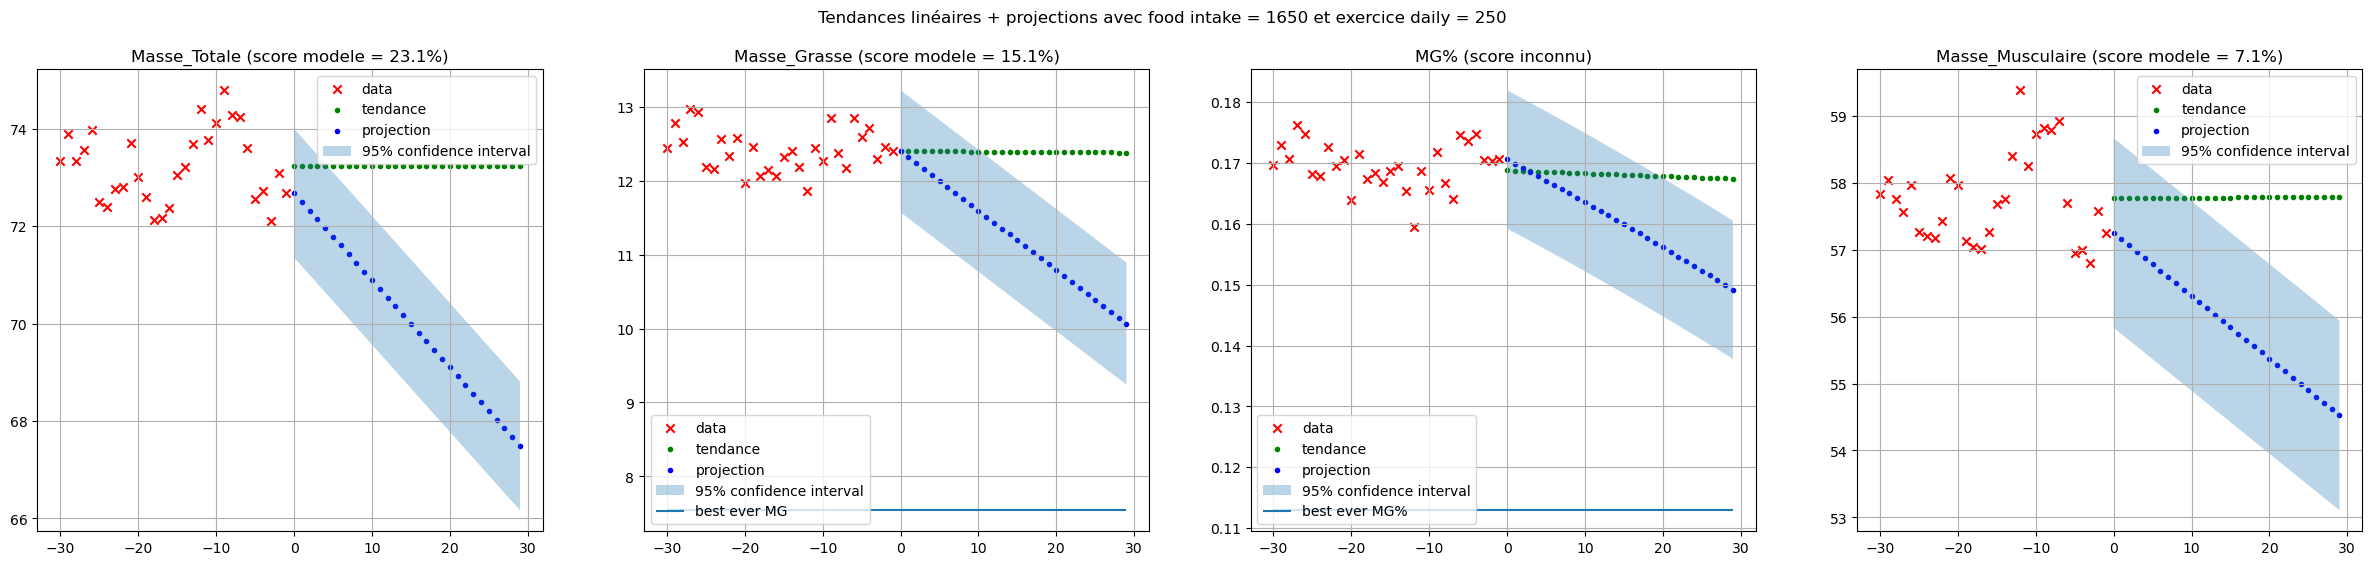

In [24]:
# Indicateurs Masse Totale, Masse Grasse, MG%, Masse Musculaire

X_past = np.array( [i for i in range(-horizon_past,0)] )
X_futur = np.array( [i for i in range(horizon_futur)] )
X = np.array([i for i in range(-horizon_past, horizon_futur)])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30,6))

for i, name in enumerate(data_columns):
    
    # tendances
    brr = linear_model.BayesianRidge()
    # brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    data_past = df_all[name][-horizon_past:].to_numpy()
    brr.fit( X_past.reshape(-1,1), data_past )
    
    data_futur = brr.predict(X_futur.reshape(-1,1))
    
    std = np.sqrt(1/brr.alpha_)
   
    axs[i].scatter(X_past, data_past, marker='x', color='red', label='data')
    axs[i].scatter(X_futur, data_futur, marker='.', color='green', label='tendance')
    if name=='MG%':
        titre = name + ' (score inconnu)'
    else:
        titre = name + ' (score modele = ' + f'{scores[name]*100:.1f}%)'
    axs[i].set_title(titre)
    axs[i].grid(True)
    
    # predictions avec hypothèses food intake et exercices
    if name=='MG%':
        y_pred_mt = np.array([ df_all['Masse_Totale'][-1] + X_futur * daily_delta['Masse_Totale'] ]).reshape(-1,1)
        y_pred_mg = np.array([ df_all['Masse_Grasse'][-1] + X_futur * daily_delta['Masse_Grasse'] ]).reshape(-1,1)
        y_pred = np.array([ y_pred_mg[j] / y_pred_mt[j] for j in list(X_futur)]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = np.array(noises['Masse_Grasse'] / df_all['Masse_Totale'][-1])  # estime une std sur MG%
    else:
        last_y = data_past[-1]
        dd = daily_delta[name]
        y_pred = np.array([ last_y + X_futur * dd ]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = noises[name]
    
    y_min = np.squeeze(y_pred - 1.96 * y_std)
    y_max = np.squeeze(y_pred + 1.96 * y_std)
    axs[i].fill_between(
        X_futur,
        y_min,
        y_max,
        alpha=0.3,
        label=r"95% confidence interval",
    )
    
    if name=='MG%':
        axs[i].hlines(best_ever_mgp, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG%')
    if name=='Masse_Grasse':
        axs[i].hlines(best_ever_mg, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG')
        
    axs[i].legend()
    
fig.suptitle(f'Tendances linéaires + projections avec food intake = {food_intake:.0f} et exercice daily = {exos_avg:.0f}')

plt.show()

In [25]:
MAX_CAL = 1650.0
PERIODE = 45
n_jours = 15
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 30 derniers jours = 1819 kcals/jour
Target quotidienne sur les 15 prochains jours pour tenir 1650 kcals quotidiennes = 1311 kcals/jour


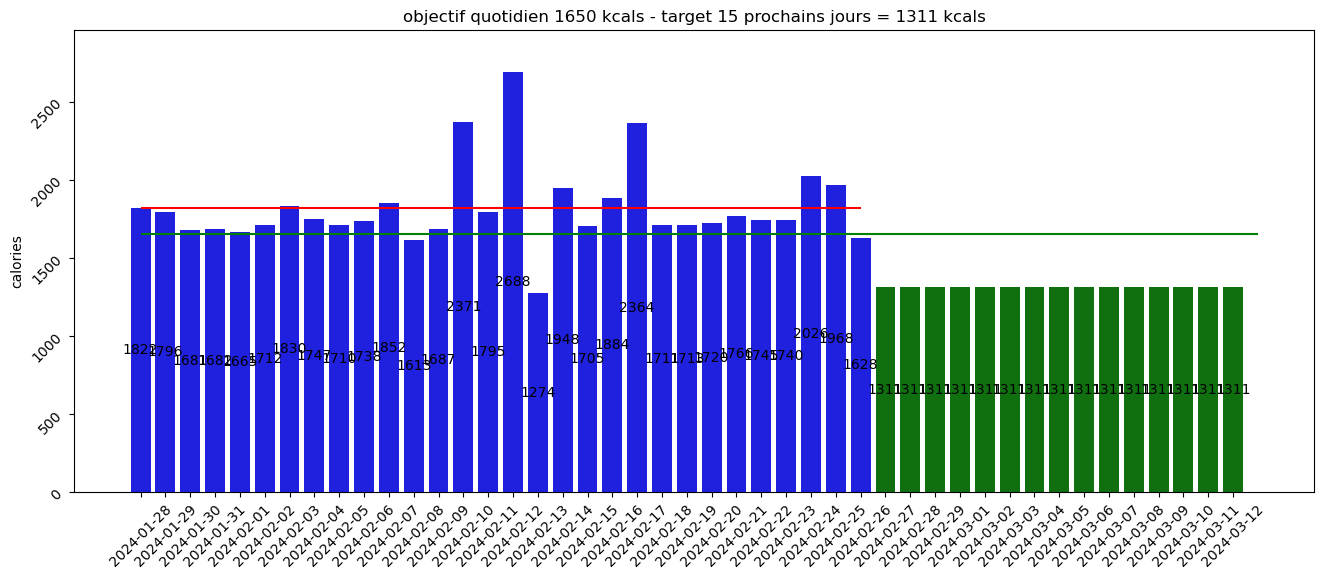

In [26]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

# Graphes

In [27]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [28]:
def plot_general(longueur=15,
                 year=2023,
                 month=11,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

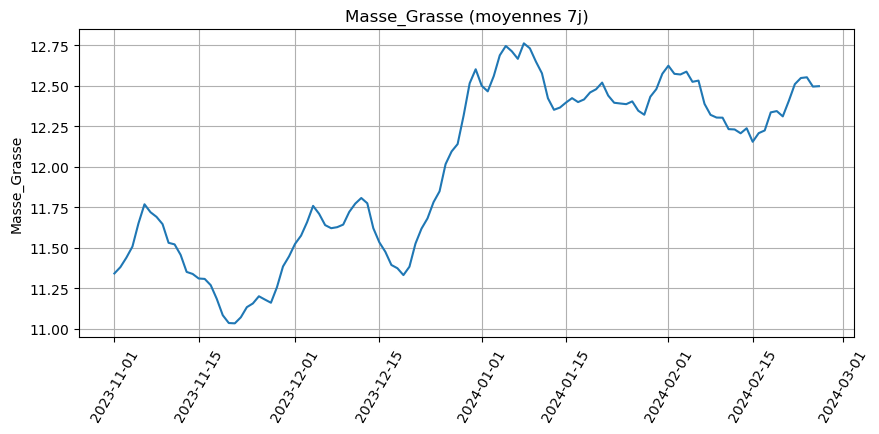

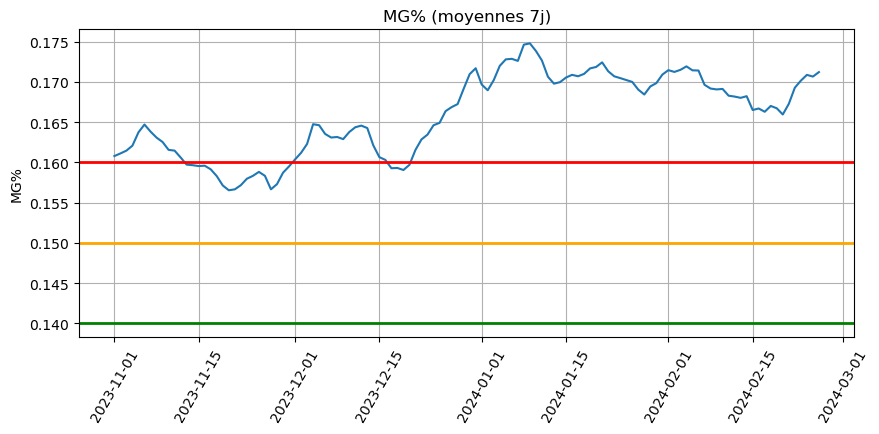

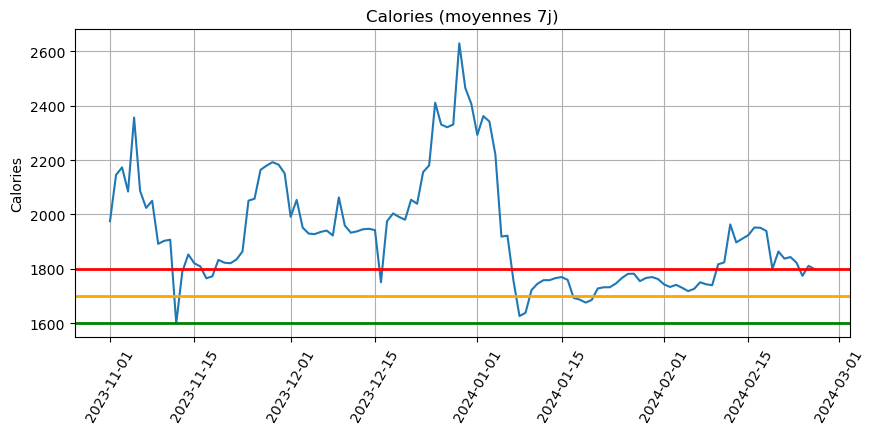

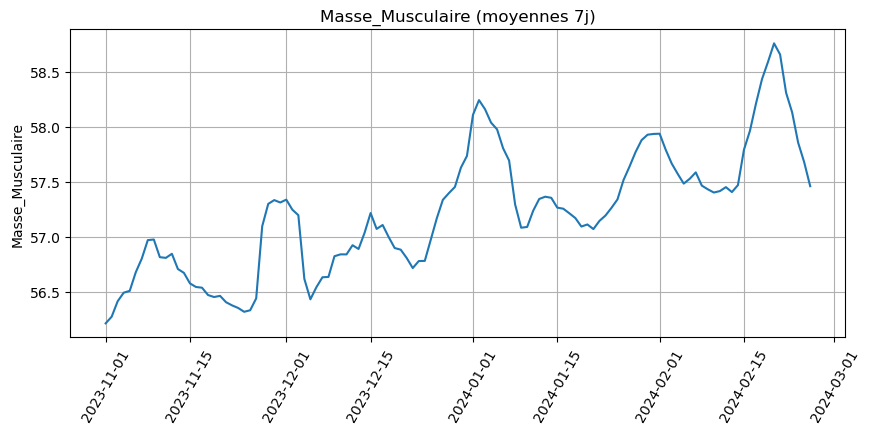

In [29]:
plot_general(longueur=7)

In [30]:
# vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

# ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

In [31]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [32]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [33]:
def plot_general3(longueur=15,
                 year=2023,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [34]:
# ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [35]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [36]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [37]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [38]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [39]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [40]:
# ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))